 # Bidprice Prediction
 Based on the feature engineering and different combinations of model and formula which serves as different agents in the auction, this file aims at identifying the best combination (agent) and game theroy based approach.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

## Import and Pre-process the Data
This section imports the data and conducts the feature engineering.

In [0]:
def get_dummy_columns(df):
    # convert categorical variable into dummy variables
    df_dum = pd.get_dummies(df, dummy_na=True, columns=['weekday', 'hour', 'OS', 'browser', 'region', 'city', 
                                                        'adexchange', 'slotvisibility', 'slotformat', 'creative', 
                                                        'slotprice_bin','advertiser','keypage','size'])
    df_dum = df_dum.join(df['usertag'].astype(str).str.strip('[]').str.get_dummies(','))
    df_dum = df_dum.drop(['usertag'],axis=1)
    
    return df_dum

In [0]:
def encode_slotprice_bin(df):
    # categorise the slotprice
    df['slotprice_bin'] = 0
    df.loc[df['slotprice'] <= 10, 'slotprice_bin'] = 1
    df.loc[(df['slotprice'] > 10) & (df['slotprice'] <= 50), 'slotprice_bin'] = 2
    df.loc[(df['slotprice'] > 50) & (df['slotprice'] <= 100), 'slotprice_bin'] = 3
    df.loc[df['slotprice'] > 100, 'slotprice_bin'] = 4
    df['slotprice_bin'] = df['slotprice_bin'].astype(np.uint8)
        
    return df

In [0]:
def adjust_feature(target, df):
    # collect feature difference
    drop_feature = np.setdiff1d(df.columns, target.columns)
    add_feature = np.setdiff1d(target.columns, df.columns)
    
    # adjust feature
    df.drop(drop_feature, axis=1, inplace=True)
    df = df.assign(**{c: 0 for c in add_feature})
    
    # adjust feature order
    df_new = pd.DataFrame()
    for key in target:
        df_new[key] = df[key]
    
    return df_new

In [0]:
def feature_engineering(df, target=None, test=False, train=False):
    
    print("Input shape:\t{}".format(df.shape))
    # calcuate the slot size
    df['size'] = df['slotwidth'] * df['slotheight']
    
    # split user agent information
    df['OS'], df['browser'] = zip(*df['useragent'].map(lambda x: x.split('_')))
    
    # set slotprice bin
    df = encode_slotprice_bin(df)
    
    if test is True:
        # drop some features
        df = df.drop(['bidid','userid','IP','url','urlid','slotid','useragent',
                      'domain','slotwidth', 'slotheight','slotprice'],axis=1)
        
        # create dummies for categarical variables
        df = get_dummy_columns(df)
        
        # adjust features to match train set
        df = adjust_feature(target,df)
        
        df.fillna(0, inplace=True)
        print("Output shape:\t{}".format(df.shape))
        
        return df
    
    else:       
        # output label
        y = df['click']
        
        df = df.drop(['click','bidid','userid','IP','url','urlid','slotid',
                      'useragent','bidprice','payprice','domain','slotwidth',
                      'slotheight','slotprice'],axis=1)
                       
        # Undersample the training dataset
        if train is True:
            col_name = list(df.columns)
            sampler = RandomUnderSampler(random_state=3 ,ratio={1:1786,0:10716})
            df_sample, y = sampler.fit_sample(df,y)
            df = pd.DataFrame(df_sample,columns=col_name)
            
            # create dummies for categarical variables  
            df = get_dummy_columns(df)
            
        else:
            # create dummies for categarical variables  
            df = get_dummy_columns(df)
            
            # adjust features to match train set
            df = adjust_feature(target,df)
        
        df.fillna(0, inplace=True)
        print("Output shape:\t{}".format(df.shape))
        
        return df, y

In [0]:
# import data
train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/AI/data/train.csv')
validation = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/AI/data/validation.csv')
test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/AI/data/test.csv')

In [9]:
# conduct feature engineering
X_train, y_train = feature_engineering(train, train=True)
print('\n')
X_validation, y_validation = feature_engineering(validation, target=X_train)
print('\n')
X_test = feature_engineering(test, target=X_train, test=True)

Input shape:	(2430981, 25)
Output shape:	(12502, 714)


Input shape:	(303925, 25)
Output shape:	(303925, 714)


Input shape:	(303375, 22)
Output shape:	(303375, 714)


## Build Models and Predict CTR (Validation Set)
This section builds different models to predict CTR of the validation set.

In [0]:
# set three classifers
clf_LR = LogisticRegression(penalty='l1', max_iter=100, C=0.1, solver='saga',class_weight='unbalanced')
clf_RF = RandomForestClassifier(n_estimators=50, random_state=0)
clf_xgb = xgboost.XGBClassifier(max_depth=5, n_estimators=200, min_child_weight=3, learning_rate=0.05,
                                colsample_bytree=0.8, silent=0, subsample=0.8, objective='binary:logistic')
clf_set = [clf_LR,clf_RF,clf_xgb]

# labels of classifers
clf_labels = ['LR','RF','XGB']

In [0]:
# calculate pCTR
pCTR_results = pd.DataFrame(columns=clf_labels)
w = 10716/train.shape[0]

for clf, label in zip(clf_set, clf_labels):
    y_validation_proba = clf.fit(X_train,y_train).predict_proba(X_validation)
    pCTR_results[label] = y_validation_proba[:,1]/(y_validation_proba[:,1]+(1-y_validation_proba[:,1])/w)

## Predict Bid Price (Validation Set)
This section calculates the predicted bid price based on various combinations of  model and formula.

In [0]:
def calculate_bidprice(pCTR,formula):
    
    df_bidprice = pd.DataFrame()
    
    for label in clf_labels:
        CTR = pCTR[label]
        
        # linear bidding formula
        if formula == 'linear':
            df_bidprice[label+'_'+'linear'] = 126 * (CTR/avgCTR)
        
        # quadratic formula
        if formula == 'quadratic':
            df_bidprice[label+'_'+'quadratic'] = 168 * (CTR/avgCTR)**2
                
        # ORTB
        if formula == 'ORTB':
            df_bidprice[label+'_'+'ORTB'] = np.sqrt(20 / 1e-6 * CTR + 20 ** 2) - 20
                
    return df_bidprice

In [0]:
# using different formulas to calculate the predicting bidprice
avgCTR = sum(train['click'])/train.shape[0]

df_linear = calculate_bidprice(pCTR_results,formula='linear')
df_quadratic = calculate_bidprice(pCTR_results,formula='quadratic')
df_ORTB = calculate_bidprice(pCTR_results,formula='ORTB')

result_set = [df_linear,df_quadratic,df_ORTB]
df_bidprice = pd.concat(result_set, axis=1)

In [20]:
df_bidprice.head()

,LR_linear,RF_linear,XGB_linear,LR_quadratic,RF_quadratic,XGB_quadratic,LR_ORTB,RF_ORTB,XGB_ORTB
0,55.174117,48.053406,25.628753,32.213579,24.435237,6.950613,62.821619,57.625865,38.313333
1,25.668444,83.631096,18.952543,6.972159,74.012278,3.801046,38.353163,80.950362,31.174587
2,27.099016,48.053406,15.350596,7.770970,24.435237,2.493553,39.771010,57.625865,26.873727
3,29.847815,31.371260,14.806595,9.427429,10.414349,2.319950,42.405006,43.818019,26.189373
4,39.563382,15.366955,20.611810,16.563611,2.498871,4.495732,50.935316,26.894151,33.038612


## Multiagent Bidding Process (Validation Set)
This section utilizes the predicted bidprice results of the pervious section and conducts the auction based on the winning criterion 2. After the auction, the agent wins the most click is the best combination.

In [0]:
bidprice = df_bidprice.copy()

# add the 'click' and 'payprice' features from the validation set to bidprice dataframe
bidprice['click'] = validation['click']
bidprice['validation'] = validation['payprice']

In [0]:
# define the function of multiagent bidding auction
def multiagent_bidding(df, df_other, self_team, budget=6250*1000, num=1):
    
    result = np.zeros((num, 6))
    N =  df.shape[0]
    
    # bidding agents
    for i in range(num):
        bid_self = df[self_team].values 
        bid_other_max = np.max(df_other, axis=1)
        bid_other_max.sort_index(inplace=True)
        
        won = np.where(bid_self > bid_other_max, True, False)

        # if won, then pay bid other max; else pay 0
        payprice = np.where(won, bid_other_max, 0)
    
        df_winning = df_other[['click']][won].copy()
        df_winning 
        df_winning['payprice'] = payprice[won] # pay 2nd price
        
        
        df_winning['total_cost'] = df_winning['payprice'].cumsum()
        final_df = df_winning[df_winning['total_cost'] <= budget]
        
        # stats
        click = final_df['click'].sum()
        impression = final_df.shape[0]
        totalCPM = final_df['payprice'].sum()
        spend = totalCPM / 1000

        if impression > 0:
            CTR = click / impression
            CPM = totalCPM / impression
        else:
            CTR = np.NaN
            CPM = np.NaN

        if click > 0:
            CPC = spend / click
        else:
            CPC = np.NaN
        
        result[i,:] = np.array([spend, impression, click, CTR, CPM, CPC])
        
    res = np.mean(result, axis=0)
    
    # unpack result
    spend, imp, click, CTR, CPM, CPC = res.T
    
    return spend, imp, click, CTR, CPM, CPC

In [0]:
# Bidding Approach 1: use the original predicted bidprice to bid (approaches list will be mentioned in the last section)
click_list_1 = []
teams = ['LR_linear', 'RF_linear', 'XGB_linear', 'LR_quadratic', 'RF_quadratic', 
         'XGB_quadratic', 'LR_ORTB', 'RF_ORTB', 'XGB_ORTB','validation']

for team in teams: 
    
    # self and other
    df_self = bidprice[[team]]
    df_other = bidprice.drop(team, axis=1)
    
    spend, imp, click, CTR, CPM, CPC = multiagent_bidding(df_self, df_other, self_team=team, num=1)
    click_list_1.append([team , imp, click, CPM, CTR, CPC])

In [23]:
pd.DataFrame(click_list_1 , columns=['team name', 'impression', 'click','CPM', 'CTR' ,'CPC'], )

,team name,impression,click,CPM,CTR,CPC
0,LR_linear,11402.0,2.0,83.271230,0.000175,474.729284
1,RF_linear,9794.0,0.0,81.001110,0.000000,NaN
2,XGB_linear,3831.0,2.0,83.299185,0.000522,159.559589
3,LR_quadratic,5478.0,4.0,1140.894384,0.000730,1562.454859
4,RF_quadratic,5154.0,5.0,1211.919892,0.000970,1249.247025
5,XGB_quadratic,1212.0,6.0,5155.491040,0.004950,1041.409190
6,LR_ORTB,37694.0,1.0,55.677505,0.000027,2098.707863
7,RF_ORTB,18431.0,0.0,55.796602,0.000000,NaN
8,XGB_ORTB,15689.0,4.0,53.814457,0.000255,211.073755
9,validation,89573.0,26.0,68.290976,0.000290,235.270292


In [0]:
# Bidding Approach 2: only keep the highest 20k bidprice for each agent and conduct the auction
N = 20 * 1000
test1 = bidprice.mask(bidprice.rank(axis=0, method='max', ascending=False) > N, 0)

In [0]:
click_list_2 = []
teams = ['LR_linear', 'RF_linear', 'XGB_linear', 'LR_quadratic', 'RF_quadratic', 
         'XGB_quadratic', 'LR_ORTB', 'RF_ORTB', 'XGB_ORTB','validation']

for team in teams: 
    
    # self and other
    df_self = test1[[team]]
    df_other = test1.drop(team, axis=1)
    
    spend, imp, click, CTR, CPM, CPC = multiagent_bidding(df_self, df_other, self_team=team, num=1)
    click_list_2.append([team , imp, click, CPM, CTR, CPC])

In [26]:
pd.DataFrame(click_list_2 , columns=['team name', 'impression', 'click','CPM', 'CTR' ,'CPC'], )

,team name,impression,click,CPM,CTR,CPC
0,LR_linear,0.0,0.0,NaN,NaN,NaN
1,RF_linear,0.0,0.0,NaN,NaN,NaN
2,XGB_linear,0.0,0.0,NaN,NaN,NaN
3,LR_quadratic,1522.0,3.0,3849.405410,0.001971,1952.931678
4,RF_quadratic,1370.0,4.0,4554.230506,0.002920,1559.823948
5,XGB_quadratic,469.0,6.0,13021.696387,0.012793,1017.862601
6,LR_ORTB,0.0,0.0,NaN,NaN,NaN
7,RF_ORTB,0.0,0.0,NaN,NaN,NaN
8,XGB_ORTB,0.0,0.0,NaN,NaN,NaN
9,validation,17299.0,13.0,0.000751,0.000751,0.001000


## Predict Bid Price (Test Set)
This section uses the best combination ( Logistic Regression + ORTB) to calculate the bid price of test data set.







In [0]:
def predict_testset(clf, formula, export=False):
    
    # import submission file
    test_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/AI/data/Group_xx.csv')
    
    # calculate parameter
    w = 10716/2430981 # train.shape[0] = 2430981
    
    # predict CTR
    y_test_proba = clf.fit(X_train,y_train).predict_proba(X_test)
    pCTR_test = y_test_proba[:,1]/(y_test_proba[:,1]+(1-y_test_proba[:,1])/w)
    
    # calculate bid price for test set
        # linear bidding formula
    if formula == 'linear':
        test_df['bidprice'] = 126 * (pCTR_test/avgCTR)
        
        # quadratic formula
    if formula == 'quadratic':
        test_df['bidprice'] = 1.25 * 168 * (pCTR_test/avgCTR)**2  # increase the level of bidprice
                
        # ORTB
    if formula == 'ORTB':
        test_df['bidprice'] = np.sqrt(20 / 1e-6 * pCTR_test + 20 ** 2) - 20
    
    # export csv file
    if export is True:
        test_df.to_csv('/content/gdrive/My Drive/Colab Notebooks/AI/data/result.csv',index=False)
    
    return test_df

In [0]:
test_xgb = predict_testset(clf_xgb,'quadratic', export=True)

In [29]:
test_xgb.head()

,bidid,bidprice
0,366c563de7d90feb9d4dab53e795a93fb3157387,277.862732
1,29167d4caa719788b5a342dbaa25151d53121f80,2839.704102
2,ff8bc3f4d44a3ea60c5f3a3a8fbe7cd98fb2966e,6.452158
3,844c2da00d45315f20b748ec131c26ee99a7cbc7,63.359745
4,c6017f0ad0c44d7d0c9b62583ea863f28941c0ca,55.147121


## Game Theory Based Approaches Experiments
This section conducts different approaches to modify the predicted bid price of the test set and compares the results of these approaches in the leaderboard.

Approaches List: (some of the approaches have been mentioned and achieved above)
1. use predicted results of the original model and formula
- only keep the highest 20k bidprice for the predicted results
- only keep the highest 60 bidprice for the predicted results and try to use all the budget
- magnify the quadratic formula by 1.25 times and use the predicted results
- based on results of the fourth approach, set the first 100k bid's bidprice as 0
- based on results of the fourth approach, set the bidprice of the highest 20k bidprice as 0 and magnify the rest bidprice by 5 times
- ...other approaches will be explained in the corresponding cells

In [0]:
# Bidding Approach 2
N = 20 * 1000
test_2 = test_xgb.mask(test_xgb.rank(axis=0, method='max', ascending=False) > N, 0)

In [0]:
# Bidding Approach 3
N = 60
test_3 = test_xgb.mask(test_xgb.rank(axis=0, method='max', ascending=False) > N, 0)

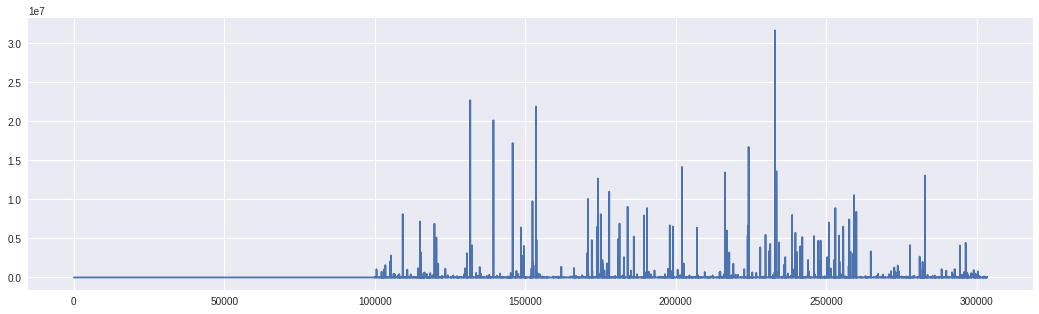

In [32]:
# Bidding Approach 5
test_5 = test_xgb.copy()
test_5.loc[:100001,['bidprice']]=0

x_axis=np.arange(303375)
plt.figure(figsize=(18,5))
plt.plot(x_axis,test_5['bidprice'])

In [0]:
# Bidding Approach 6
test_6 = test_xgb.sort_values('bidprice', ascending=False) 
test_6.bidprice[0:20000] = 0 
test_6.bidprice = test_6.bidprice * 5
test_6 = test_6.sort_index()

In [0]:
# Bidding Approach 7: only keep the 20k to 40k highest bidprice and multiply by 5
test_7 = test_xgb.sort_values('bidprice', ascending=False) 
test_7.bidprice[0:20000] = 0 
test_7.bidprice[40000:] = 0
test_7 = test_7.sort_index()
test_7.bidprice = test_7.bidprice * 5

In [0]:
# Bidding Approach 8: only keep the 50k to 120k highest bidprice and multiply by 5
test_8 = test_xgb.sort_values('bidprice', ascending=False) 
test_8.bidprice[0:50000] = 0 
test_8.bidprice[120000:] = 0
test_8 = test_8.sort_index()
test_8.bidprice = test_8.bidprice * 5

In [0]:
# Bidding Approach 9: set the 220k highest bidprice as 0 and keep the rest bidprice, multiply by 5
test_9 = test_xgb.sort_values('bidprice', ascending=False) 
test_9.bidprice[0:220000] = 0 
test_9.bidprice = test_9.bidprice * 5
test_9 = test_9.sort_index()

In [0]:
# Bidding Approach 10: only keep the 100k to 180k highest bidprice and multiply by 6
test_10 = test_xgb.sort_values('bidprice', ascending=False) 
test_10.bidprice[0:100000] = 0 
test_10.bidprice[180000:] = 0
test_10 = test_10.sort_index()
test_10.bidprice = test_10.bidprice * 6

In [0]:
# Bidding Approach 11: only keep the 20k to 120k highest bidprice and multiply by 5
test_11 = test_xgb.sort_values('bidprice', ascending=False) 
test_11.bidprice[0:20000] = 0 
test_11.bidprice[120000:] = 0
test_11 = test_11.sort_index()
test_11.bidprice = test_11.bidprice * 5

In [0]:
# Bidding Approach 12: only keep the 50k to 120k highest bidprice and multiply by 10
test_12 = test_xgb.sort_values('bidprice', ascending=False) 
test_12.bidprice[0:50000] = 0 
test_12.bidprice[120000:] = 0
test_12 = test_12.sort_index()
test_12.bidprice = test_12.bidprice * 10

In [0]:
test_12.to_csv('/content/gdrive/My Drive/Colab Notebooks/AI/data/result_14.csv')

In [0]:
# Bidding Approach 13: only keep the 80k to 120k highest bidprice and multiply by 5
test_13 = test_xgb.sort_values('bidprice', ascending=False) 
test_13.bidprice[0:80000] = 0 
test_13.bidprice[120000:] = 0
test_13 = test_13.sort_index()
test_13.bidprice = test_13.bidprice * 5

In [0]:
test_13.to_csv('/content/gdrive/My Drive/Colab Notebooks/AI/data/result_15.csv')

In [0]:
# Bidding Approach 14: only keep the 80k to 120k highest bidprice and multiply by 11
test_14 = test_xgb.sort_values('bidprice', ascending=False) 
test_14.bidprice[0:80000] = 0 
test_14.bidprice[120000:] = 0
test_14 = test_14.sort_index()
test_14.bidprice = test_14.bidprice * 11

In [0]:
test_14.to_csv('/content/gdrive/My Drive/Colab Notebooks/AI/data/result_16.csv')